In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.signal as sig
import RigolWFM.wfm as rigol
%matplotlib inline

16384

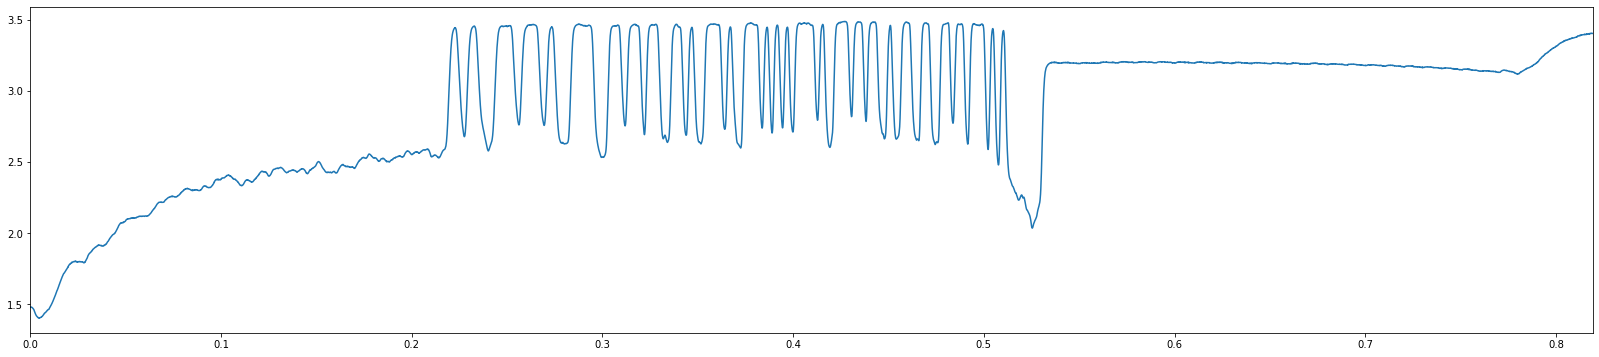

In [39]:
#wf = rigol.Wfm.from_file('barcode_test_varspeed.wfm', 'DS1054Z')
wf = rigol.Wfm.from_file('barcode_test2.wfm', 'DS1054Z')
data = wf.channels[0].volts

downsampling = 500
data = scipy.signal.decimate(data, downsampling, ftype='fir')
off = 1000
data = data[off:off+16384]
td = wf.channels[0].seconds_per_point * downsampling
times = np.linspace(0, len(data)*td, len(data))

fig, ax = plt.subplots(figsize=(28, 6))
ax.plot(times, data)
ax.set_xlim([times[0], times[-1]])
len(data)

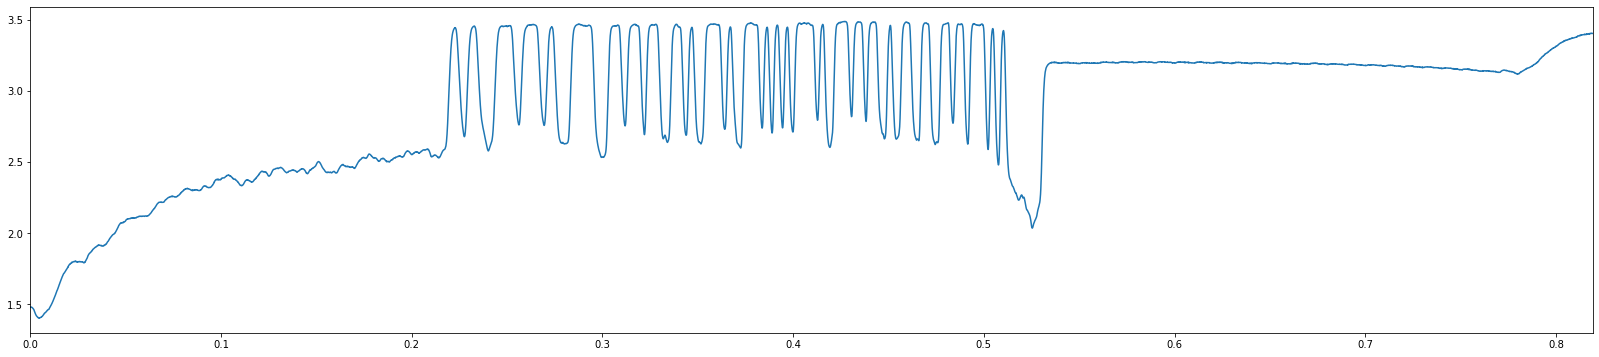

In [40]:
fig, ax = plt.subplots(figsize=(28, 6))
ax.plot(times, data)
ax.set_xlim([times[0], times[-1]])

state = '?'
last = data[0]
for t, v in zip(times, data):
    pass

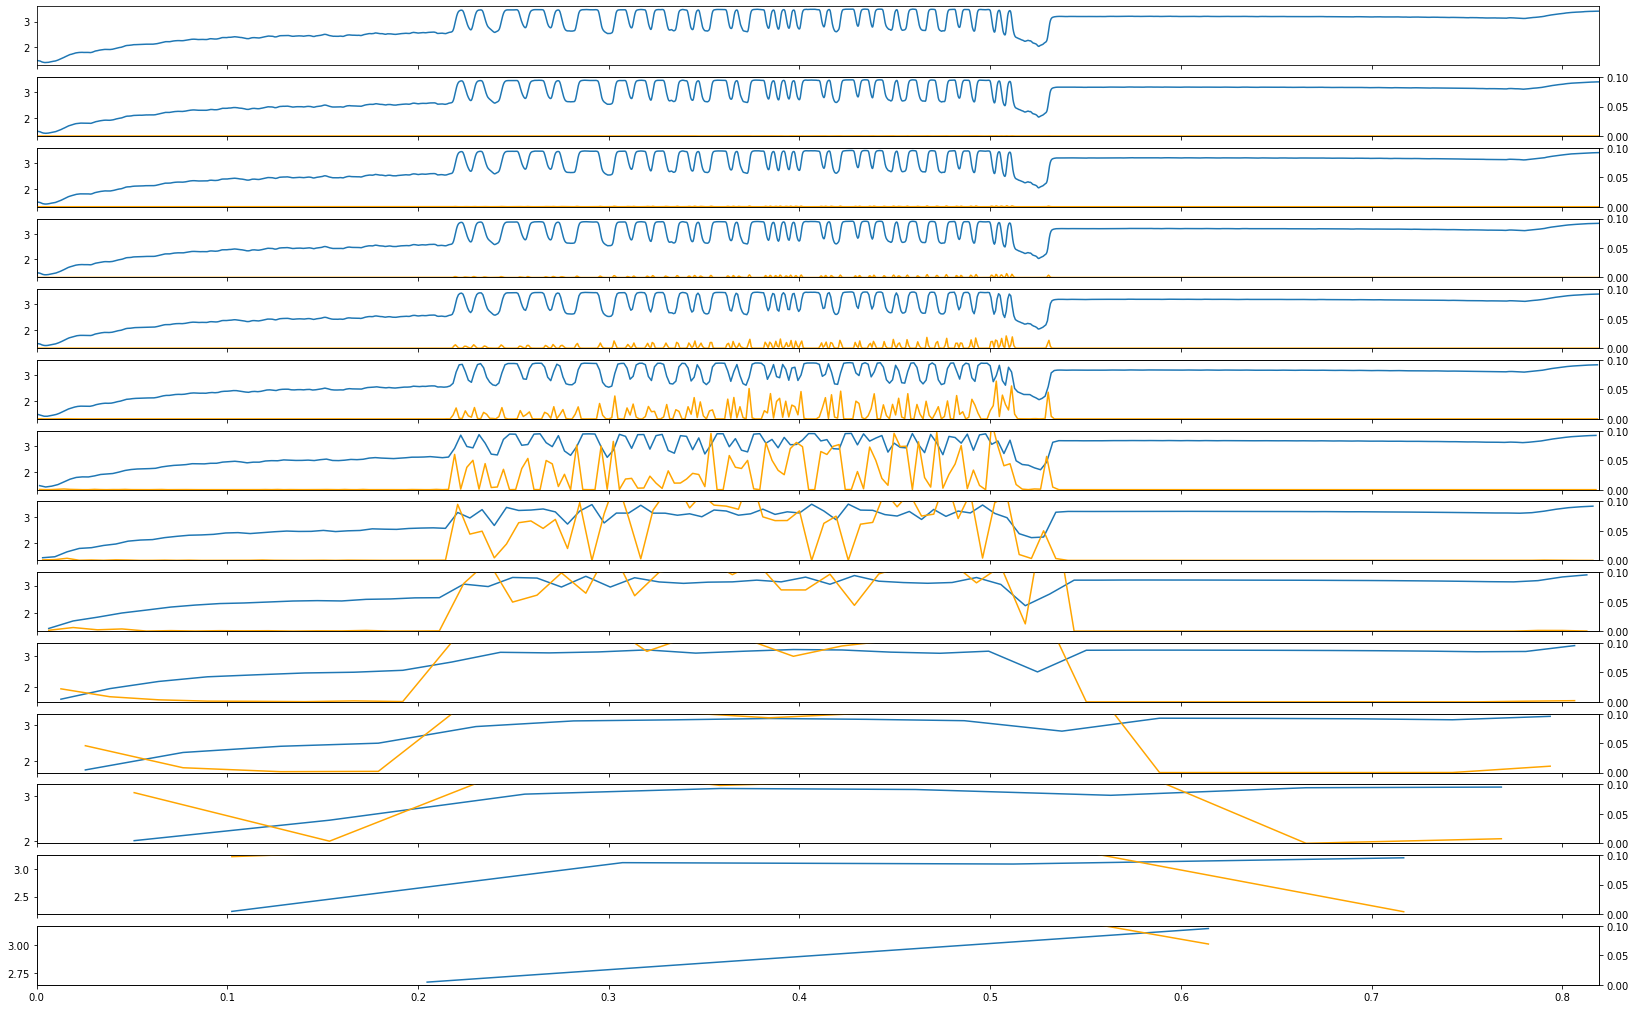

In [41]:
fig, axs = plt.subplots(14, 1, figsize=(28, 18), sharex=True)
axs[0].plot(times, data)
axs[0].set_xlim([times[0], times[-1]])

times_rem = times
meanl, varl = data, np.zeros(len(data))
while len(meanl) > 2:
    meann = (meanl[0::2] + meanl[1::2]) / 2
    varn  = ( varl[0::2] +  varl[1::2]) / 2 + ((meanl[0::2] - meann)**2 + (meanl[1::2] - meann)**2)/2
    meanl, varl = meann, varn
    times_rem = (times_rem[0::2] + times_rem[1::2])/2
    axs[1].plot(times_rem, meanl)
    tx = axs[1].twinx()
    tx.plot(times_rem, varl, color='orange')
    tx.set_ylim([0, 0.1])
    axs = axs[1:]

(0.0, 0.15)

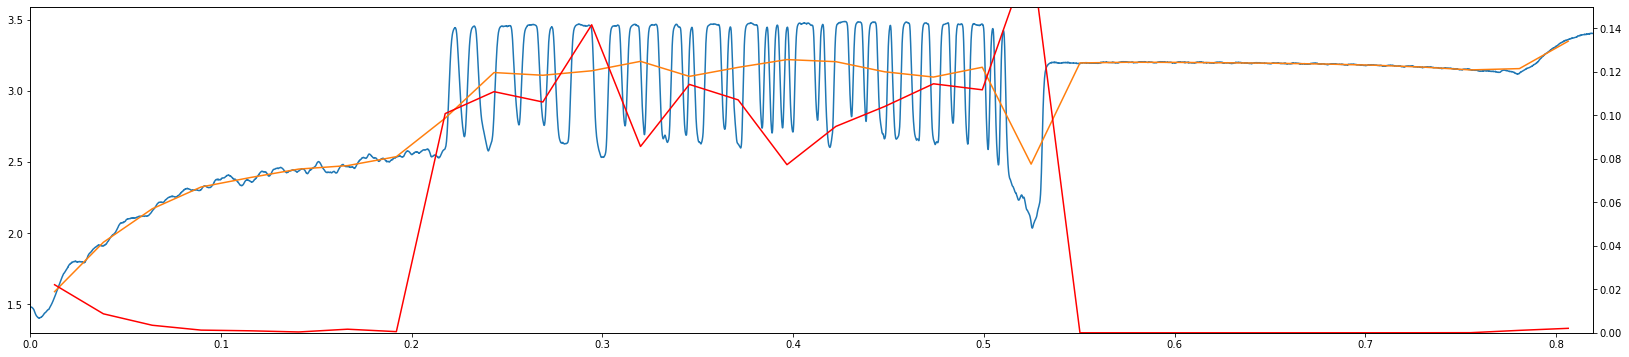

In [42]:
DECIMATION_ORDER = 9

fig, ax = plt.subplots(1, 1, figsize=(28, 6), sharex=True)
ax.plot(times, data)
ax.set_xlim([times[0], times[-1]])

times_rem = times
meanl, varl = data, np.zeros(len(data))
for _ in range(DECIMATION_ORDER):
    meann = (meanl[0::2] + meanl[1::2]) / 2
    varn  = ( varl[0::2] +  varl[1::2]) / 2 + ((meanl[0::2] - meann)**2 + (meanl[1::2] - meann)**2)/2
    meanl, varl = meann, varn
    times_rem = (times_rem[0::2] + times_rem[1::2])/2
    
ax.plot(times_rem, meanl)
tx = ax.twinx()
tx.plot(times_rem, varl, color='red')
tx.set_ylim([0, 0.15])

Runs:
power=   0.0221   0-0   (len 1) (0.000s-0.000)
power=     1.48   8-20  (len 13) (0.205s-0.512)
(16384,) (16384,)


(0.17921094217328948, 0.5631843866344195)

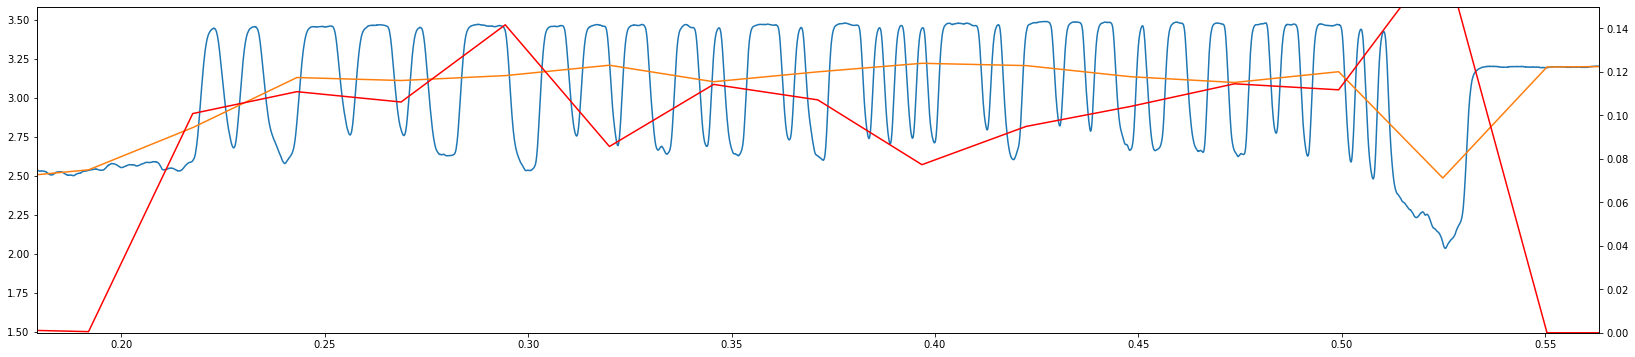

In [43]:
VARL_THRESH = 0.02

runs = [] # list of tuples of (start, end) indices, start inclusive, end exclusive (like in python array slicing)
start = None # inclusive index

for i, v in enumerate(varl > VARL_THRESH):
    if v:
        if start is None:
            start = i
    else:
        if start is not None:
            end = i
            power = math.sqrt(np.mean(varl[start:end]**2)) * (end-start)
            runs.append((power, start, end))
            start = None

runs = sorted(runs)
dec_width = 2**DECIMATION_ORDER
print('Runs:')
for power, start, end in runs:
    start_s = start*dec_width*td
    end_s   =   (end-1)*dec_width*td
    print(f'power={power:9.3g} {start:>3d}-{end-1:<3d} (len {end-start}) ({start_s:5.3f}s-{end_s:5.3f})')
    
power, start, end = runs[-1]
power /= end-start
start, end = start-1, end+1 # Add some guard zone to both indices to allow for misalignment / aliasing during variance downsampling
start_sp, end_sp = start*dec_width, end*dec_width
print(data.shape, times.shape)
data_sel = data[start_sp:end_sp]
times_sel = times[start_sp:end_sp]

fig, ax = plt.subplots(1, 1, figsize=(28, 6), sharex=True)
ax.plot(times_sel, data_sel)
ax.plot(times_rem, meanl)
tx = ax.twinx()
tx.plot(times_rem, varl, color='red')
tx.set_ylim([0, 0.15])
ax.set_xlim([times_sel[0], times_sel[-1]])

(0.17921094217328948, 0.5631843866344195)

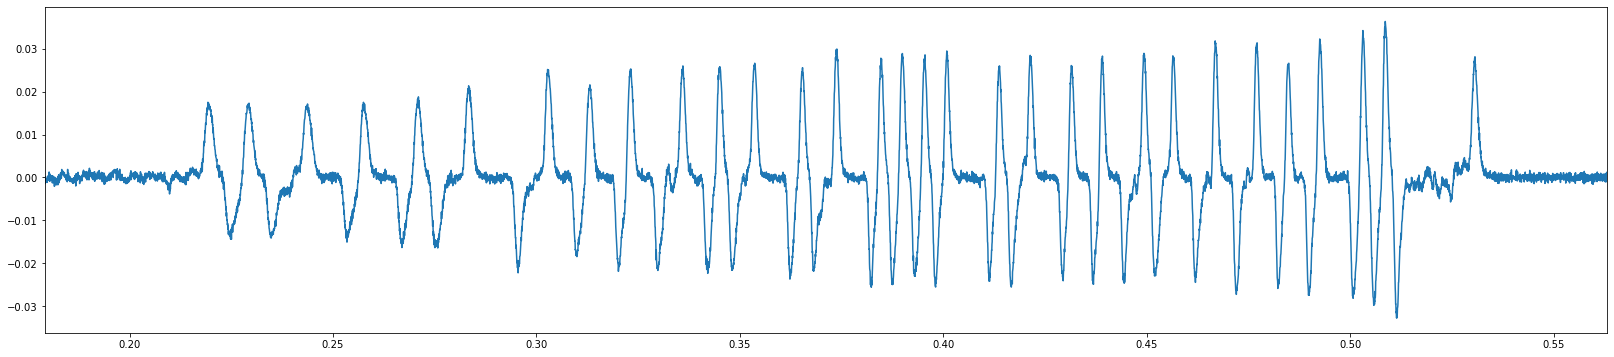

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(28, 6), sharex=True)
ax.plot((times_sel[:-1] + times_sel[1:])/2, (data_sel[1:] - data_sel[:-1]))
ax.set_xlim([times_sel[0], times_sel[-1]])

standard deviation = 0.3371236343521226
Found 119 transitions


(0.2052137509900937, 0.5364815350747509)

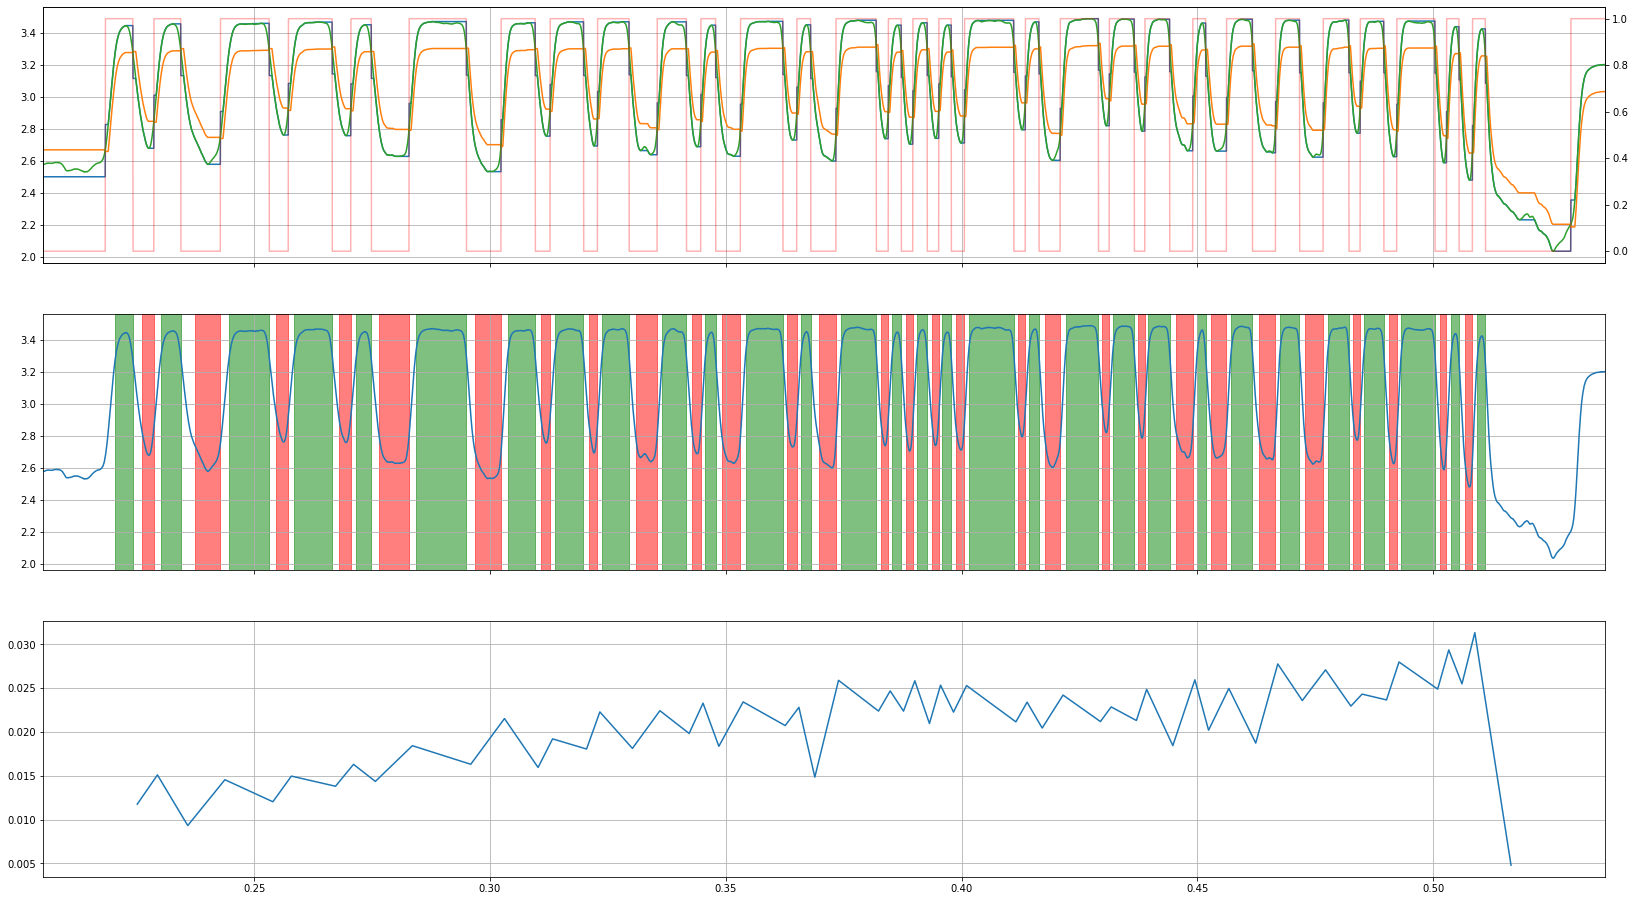

In [45]:
std = np.sqrt(power)
print(f'standard deviation = {std}')
th = std/2

outval = []
vrefout = []
vthout = []
start = 0
val = False
timestamps = []
vref = data_sel[0] + th
mins, maxs = [], []
for i, v in enumerate(data_sel):
    if abs(vref - v) > th and ((v > vref and not val) or (v < vref and val)):
            for j in range(i-1, start, -1):
                d = data_sel[j] - vref
                if val and d < -th or not val and d > th:
                    timestamps.append((j+1, val))
                    break
            timestamps.append((i, None))

            if val:
                maxs.append(vref)
            else:
                mins.append(vref)
                
            vref = (v - .9*th) if val else (v + .9*th)
            val = not val
    elif val and v > vref:
        vref = v
    elif not val and v < vref:
        vref = v
    outval.append(val)
    vrefout.append(vref)
    vthout.append((vref - th) if val else (vref + th))

timestamps = timestamps[1:-1]
print(f'Found {len(timestamps)} transitions')
#for ts, val in timestamps:
#    print(ts, val)

fig, axs = plt.subplots(3, 1, figsize=(28, 16), sharex=True)
ax = axs[0]
ax.twinx().plot(times_sel, np.array(outval).astype(int), color='red', alpha=0.3)
ax.plot(times_sel, vrefout)
ax.plot(times_sel, vthout)
ax.plot(times_sel, data_sel)
ax.grid()

ax = axs[1]
for (prev_ts, prev_val), (next_ts, next_val) in zip(timestamps[:-1], timestamps[1:]):
    if prev_val is not None:
        col = 'green' if prev_val else 'red'
        ax.axvspan(times_sel[prev_ts], times_sel[(next_ts-1)], color=col, alpha=0.5)
ax.plot(times_sel, data_sel)
ax.set_xlim([times_sel[200], times_sel[-200]])
ax.grid()
ax = axs[2]
slopes = []
slope_times = []
bar_widths = []
bar_vals = []
slope_widths = []
for (prev_ts, prev_val), (next_ts, next_val) in zip(timestamps[:-1], timestamps[1:]):
    #print(prev_ts, prev_val, next_ts, next_val)
    td = next_ts - prev_ts
        
    if prev_val is None:
        vd = abs(data_sel[next_ts] - data_sel[prev_ts])
        slope_times.append((times_sel[prev_ts] + times_sel[next_ts])/2)
        if td > 0:
            slopes.append(vd/td)
            #slopes.append(1/td)
        else:
            slopes.append(slopes[-1])
        slope_widths.append(td)
        
    else:
        bar_widths.append(td)
        bar_vals.append(prev_val)

slope_widths[-1] = slope_widths[-2] # compensate for last slope usually being way long
ax.plot(slope_times, slopes)
ax.grid()
#ax.set_xlim([slope_times[0], slope_times[-1]])
ax.set_xlim([slope_times[0] - .02, slope_times[-1] + .02])
#ax.set_xlim([times_sel[-1300], times_sel[-700]])
#ax.set_xlim([slope_times[0], slope_times[0]+(slope_times[1]-slope_times[0])*5])

0.8151881331253996


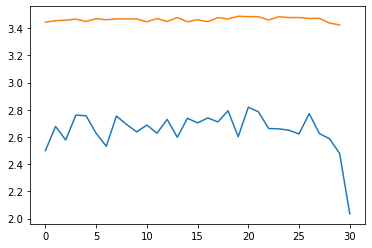

In [46]:
fig, ax = plt.subplots()
ax.plot(mins)
ax.plot(maxs)
mean_amplitude = np.mean(maxs) - np.mean(mins)
print(mean_amplitude)

(0.2252137509900937, 0.5164815350747509)

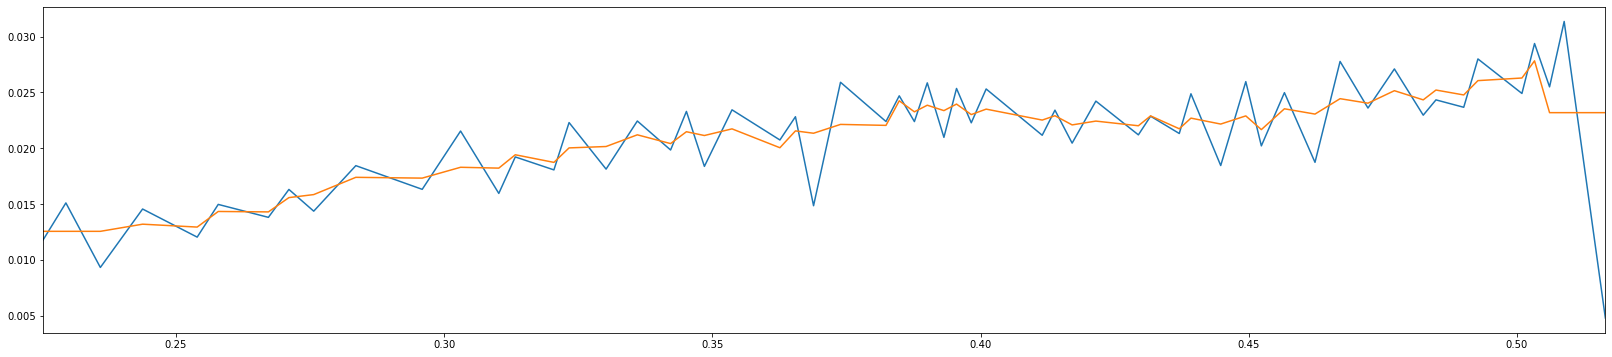

In [47]:
AVG_WIDTH = 5

cs = np.cumsum([0, *slopes]) 
slopes_mean = (cs[AVG_WIDTH:] - cs[:-AVG_WIDTH]) / float(AVG_WIDTH)
slopes_mean = np.hstack([[slopes_mean[0]]*(AVG_WIDTH//2), slopes_mean, [slopes_mean[-1]]*(AVG_WIDTH//2)])

fig, ax = plt.subplots(1, 1, figsize=(28, 6))
ax.plot(slope_times, slopes)
ax.plot(slope_times, slopes_mean)
ax.set_xlim([slope_times[0], slope_times[-1]])

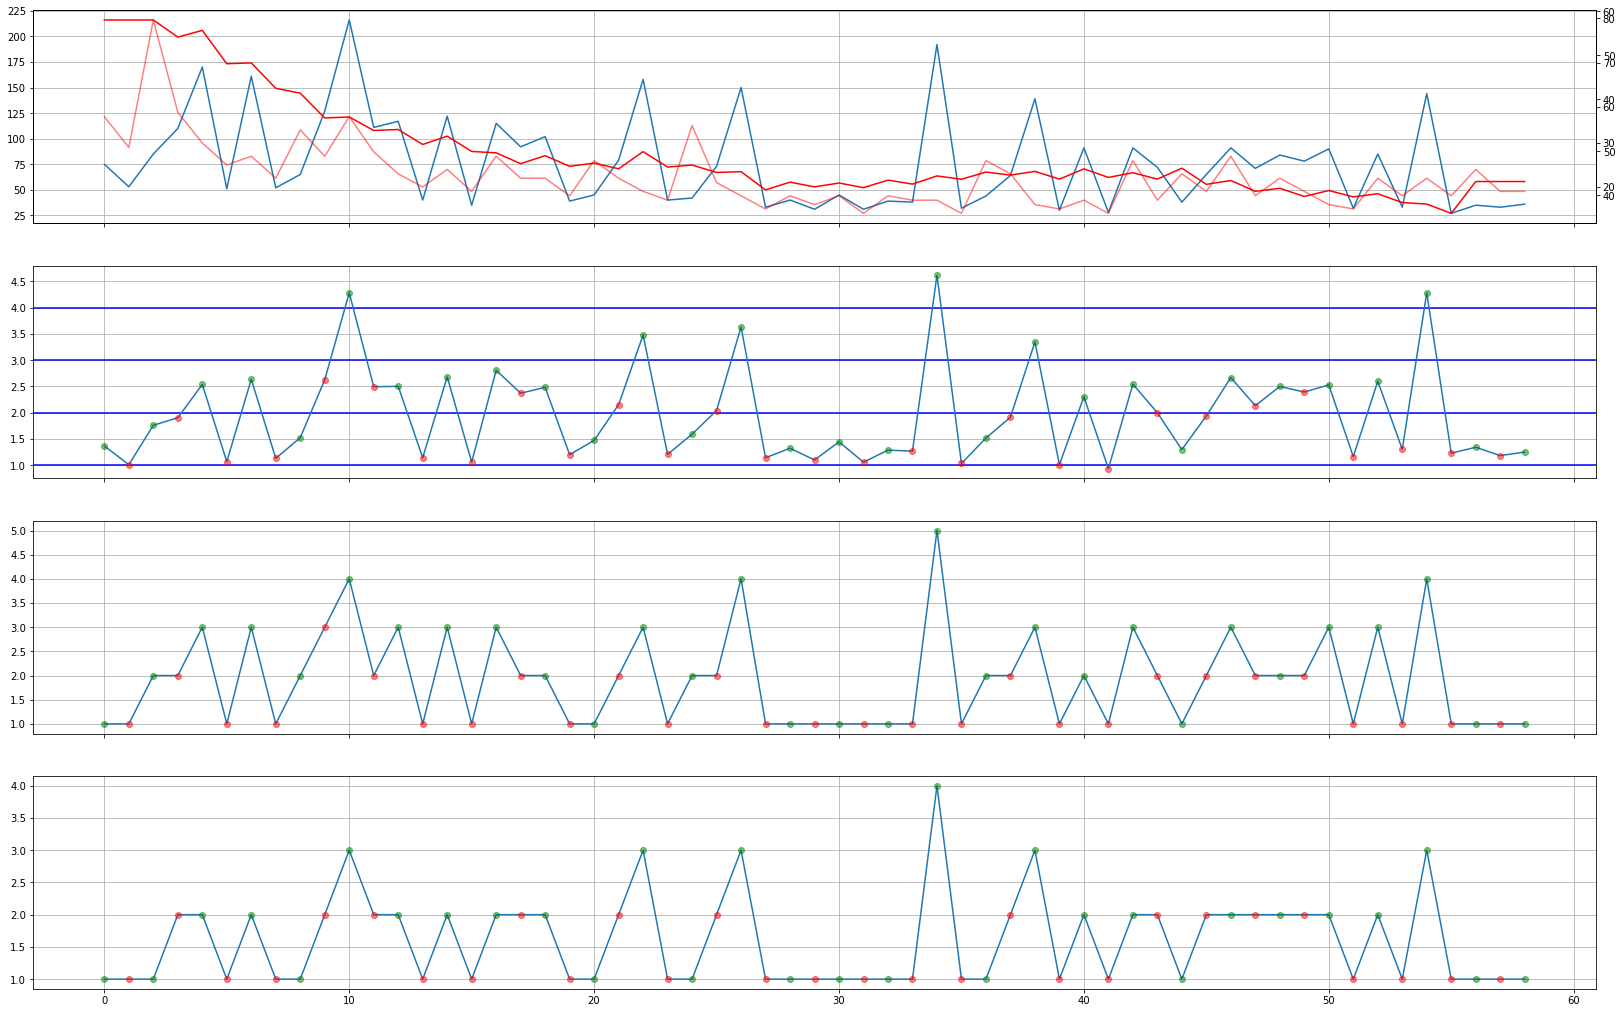

In [48]:
bar_widths_normalized = []
for bar, slope, slope_width in zip(bar_widths, slopes_mean, slope_widths):
    # All times here are in samples
    t_transition = mean_amplitude / slope
    bar += slope_width
    bar /= t_transition
    # 'bar' is now in "slit-width units"
    bar_widths_normalized.append(bar)
bar_widths_normalized = np.array(bar_widths_normalized)
bar_widths_normalized = (bar_widths_normalized - 1)*0.8 + 0.8

fig, axs = plt.subplots(4, 1, figsize=(28, 18), sharex=True)
axs[0].plot(bar_widths)
axs[0].twinx().plot(slope_widths, color='red', alpha=0.5)
axs[0].twinx().plot(1/np.array(slopes_mean), color='red')
axs[0].grid()

for i in [1,2,3,4]:
    axs[1].axhline(i, color='blue')
axs[1].plot(bar_widths_normalized)
for i, (val, w) in enumerate(zip(bar_vals, bar_widths_normalized)):
    axs[1].plot([i], [w], marker='o', color=('green' if val else 'red'), alpha=.5)
axs[1].grid()

axs[2].plot(np.round(bar_widths_normalized))
for i, (val, w) in enumerate(zip(bar_vals, bar_widths_normalized)):
    axs[2].plot([i], [round(w)], marker='o', color=('green' if val else 'red'), alpha=.5)
axs[2].grid()

ref = [1, 1, 1, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 3, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1]
ref = list(reversed(ref))
axs[3].plot(ref)
for i, w in enumerate(ref):
    axs[3].plot([i], [w], marker='o', color=('green' if i%2==0 else 'red'), alpha=.5)
axs[3].grid()

# Reference:
# 1 (1) 1 (1) M
# 3 (1) 2 (1)
# 2 (2) 2 (2) 2 (2)
# 1 (2) 2 (1) 2 (1)
# 3 (2) 1 (1) 4 (1) 

# 1 (1) 1 (1) M

# 3 (2) 1 (1) 3 (2) 1 (1) 2 (2) 2 (1)
# 2 (1) 2 (2) 3 (2) 1 (1) 2 (1) 2 (2)

# 1 (1) 1 M

# Looks good so far, we just under-estimate the barcode speed when it's fast, so the results at the start of the barcode (end of trace) are garbled.
# I suspect that we run into a slew-rate limitation of our *very* simple phototransistor circuit here, which only uses a fixed load resistor of IIRC 3k3.
# TODO: Change that load resistor to something lower and see what happens.
# Scratch that, slew rate's fine. Our hysteresis/threshold scheme is just not very precise in timing for fast edges.
# TODO: Fix that.

(0.7761473896243859, 0.7801476338693254)

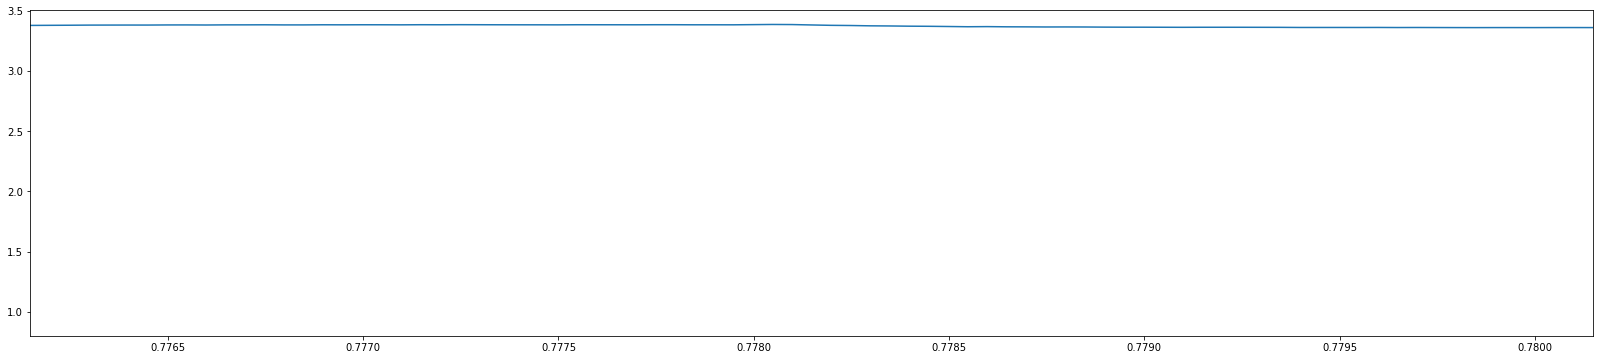

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(28, 6), sharex=True)
ax.plot(times_sel, data_sel)
ax.set_xlim([times_sel[-350], times_sel[-270]])